In [1]:
import quantbt as qbt

data = qbt.data.random_data(seed=100)[0]
print(data)

                  open        high         low       close
date                                                      
2023-01-01   96.500469   97.343832   96.342467   97.185830
2023-01-02   97.185830  100.229609   96.448123   99.491901
2023-01-03   99.491901   99.623296   98.855635   98.987029
2023-01-04   98.987029  101.396866   98.539834  100.949671
2023-01-05  100.949671  102.480134  100.447645  101.978109
...                ...         ...         ...         ...
2025-09-20   58.978186   61.374750   57.945551   60.342115
2025-09-21   60.342115   62.201244   57.007009   58.866138
2025-09-22   58.866138   61.632237   58.752728   61.518828
2025-09-23   61.518828   63.435730   61.455932   63.372835
2025-09-24   63.372835   65.733211   61.438643   63.799019

[998 rows x 4 columns]


In [2]:
import quantbt.indicators as ind
from quantbt.strategies.S_base import S_base
from quantbt.core.enums import CommissionType, DataType, TradeSizeType


class MyStrategy(S_base):
    def generate_signals(self):
        short_period, long_period = self.params

        self.sma_short = ind.talib_SMA(data.close, period=short_period)
        self.sma_long = ind.talib_SMA(data.close, period=long_period)
        self.long = ind.cross_above(self.sma_short, self.sma_long)
        self.short = ind.cross_below(self.sma_short, self.sma_long)

        return {
            "long_entries": self.long,
            "long_exits": self.short,
            "short_entries": self.short,
            "short_exits": self.long,
        }


strategy_settings = {
    "initial_capital": 100_000,
    "commission": 1.2,
    "commission_type": CommissionType.FIXED,
    "multiplier": 4,
    "data_type": DataType.OHLC,
    "default_trade_size": 1,
    "trade_size_type": TradeSizeType.FIXED,
}

In [3]:
"""
This is how we actually backtest the strategy.
We only need to set the parameters which will be automatically passed to the st.generate_signals() function
"""
st = MyStrategy(data, **strategy_settings)

params = (5, 23)
st.from_signals(params)

In [4]:
stats = st.get_stats()
print(stats)

           End Value  ROI: (%)   DD  ratio
(5, 23)  99618.40625     -0.38  0.5  -0.76


In [10]:
trades = st.get_trades()
print(trades)

     IDX  Index  Direction  EntryTime  EntryPrice                ExitTime  \
0    0.0   39.0        0.0 2023-02-09  100.871552 2023-03-28 00:00:00.000   
1    1.0   86.0        1.0 2023-03-28   84.216179 2023-03-31 00:00:00.000   
2    2.0   89.0        0.0 2023-03-31   77.247719 2023-04-05 00:00:00.000   
3    3.0   94.0        1.0 2023-04-05   84.655289 2023-04-10 00:00:00.000   
4    4.0   99.0        0.0 2023-04-10   75.757530 2023-05-28 00:00:00.000   
..   ...    ...        ...        ...         ...                     ...   
56  56.0  917.0        0.0 2025-07-06   77.787529 2025-08-09 00:00:00.000   
57  57.0  951.0        1.0 2025-08-09   66.423874 2025-08-18 00:00:00.000   
58  58.0  960.0        0.0 2025-08-18   61.454514 2025-08-31 00:00:00.000   
59  59.0  973.0        1.0 2025-08-31   64.483498 2025-09-13 00:00:00.000   
60  60.0  986.0        0.0 2025-09-13   56.414951 1969-12-31 23:59:59.999   

    ExitPrice  Volume   SL  TSL   TP  TIME_SL        PNL  Commission  Activ

            equity       Date         Bid           Open           High  \
0    100000.000000 2023-01-01   97.185830  100000.000000  100000.000000   
1    100000.000000 2023-01-02   99.491901  100000.000000  100000.000000   
2    100000.000000 2023-01-03   98.987029  100000.000000  100000.000000   
3    100000.000000 2023-01-04  100.949671  100000.000000  100000.000000   
4    100000.000000 2023-01-05  101.978109  100000.000000  100000.000000   
..             ...        ...         ...            ...            ...   
993   99630.523438 2025-09-20   60.342115   99630.523438   99630.523438   
994   99636.429688 2025-09-21   58.866138   99636.429688   99636.429688   
995   99625.820312 2025-09-22   61.518828   99625.820312   99625.820312   
996   99618.406250 2025-09-23   63.372835   99618.406250   99618.406250   
997   99618.406250 2025-09-24   63.799019   99618.406250   99618.406250   

               Low          Close  
0    100000.000000  100000.000000  
1    100000.000000  100000.

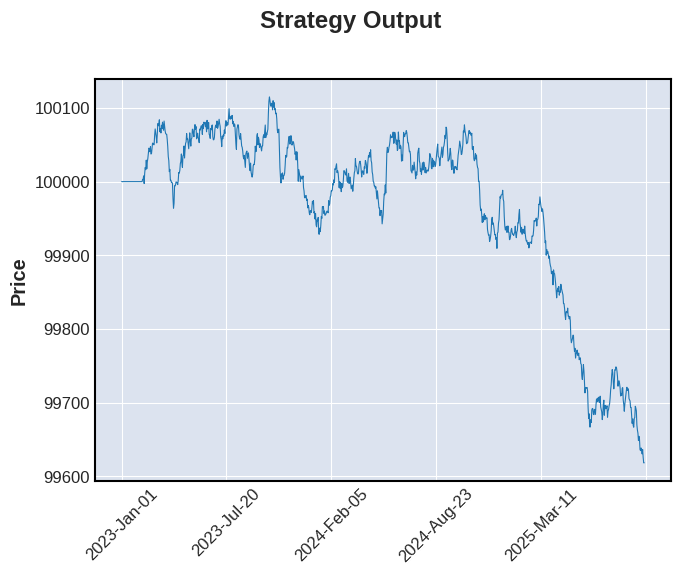

In [6]:
st.plot_equity()

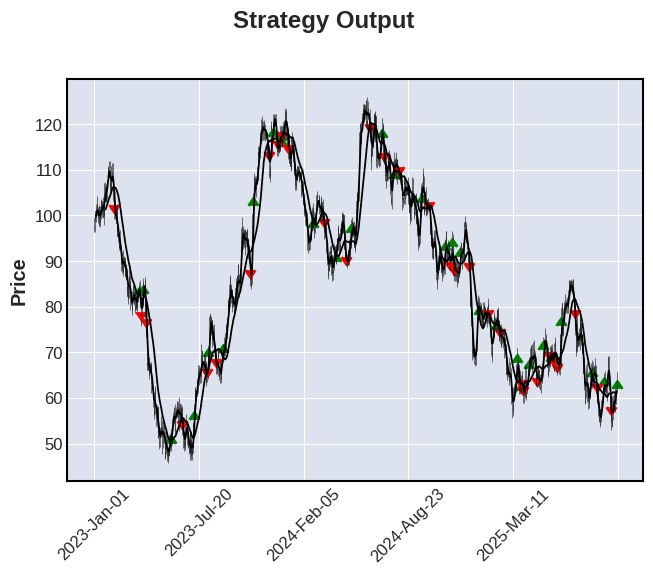

In [7]:
"""
Plotting the equity, adding the 2 MA lines, as well as markers for long and short entry signals
"""

import matplotlib

plotting = qbt.lib.plotting
subplots = [
    plotting.add_line_plot(st.sma_short),
    plotting.add_line_plot(st.sma_long),
    plotting.add_markers(
        st.long, data.close, color="green", marker_type=matplotlib.markers.CARETUP
    ),
    plotting.add_markers(st.short, data.close, color="red"),
]


qbt.lib.plotting.mpf_plot(data, subplots=subplots)

In [8]:
# import os
# from quantbt.lib import optimize
# from quantbt.core.enums import StrategyType
#
# param_combinations = {
#     "ma_short": range(8, 100, 1),
#     "ma_long": range(2, 50, 1),
# }
#
# optimisation = optimize(
#     data,
#     MyStrategy,
#     strategy_settings,
#     strategy_type=StrategyType.FROM_SIGNALS,
#     **param_combinations
#     # ma_short=range(8, 24, 1),
#     # ma_long=range(2, 15, 1),
#     # ma=range(100 + i * 10, 110 + i * 10, 1),
# )
# optimisation
#
# # sym = "Random Data"
# # for i in range(0, 50):
# #     out = f"./optimisation/{sym}-super-{i}.parquet"
# #     if not os.path.exists(out):
# #         optimisation = optimize(
# #             data,
# #             MyStrategy,
# #             # ma_short=range(8, 24, 1),
# #             # ma_long=range(2, 15, 1),
# #             # ma=range(100 + i * 10, 110 + i * 10, 1),
# #         )
# #         print(optimisation)
# #         # optimisation = optimisation.sort_values("ratio", ascending=False)
# #         # optimisation.to_parquet(f"./optimisations/{sym}-super-{i}.parquet")